In [7]:
# Importing required libraries
#https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
conda install -c conda-forge fbprophet -y

^C

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip show fbprophet

Name: fbprophet
Version: 0.6
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: Sean J. Taylor <sjtz@pm.me>, Ben Letham <bletham@fb.com>
Author-email: sjtz@pm.me
License: MIT
Location: c:\users\vivek\anaconda3\lib\site-packages
Requires: python-dateutil, LunarCalendar, setuptools-git, pystan, cmdstanpy, pandas, holidays, convertdate, numpy, Cython, matplotlib
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in c:\users\vivek\anaconda3\lib\site-packages (4.9.0)
Note: you may need to restart the kernel to use updated packages.


In [8]:

from fbprophet import Prophet



In [9]:
# Importing store data
store = pd.read_csv('store.csv')
#store.head()

In [10]:
# Importing train data
train = pd.read_csv('train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [11]:

# Importing test data
test = pd.read_csv('test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [12]:
# Checking train data
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [13]:

# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [14]:
    
# Checking data when the stores were closed
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


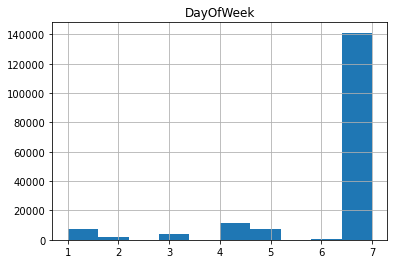

In [15]:
# Checking days when the stores were closed
train_store_closed.hist('DayOfWeek');

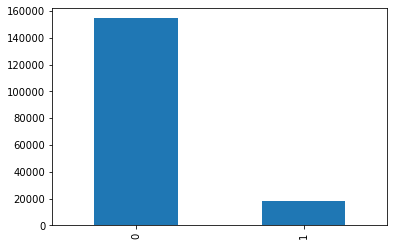

In [16]:
# Checking whether there was a school holiday when the store was closed
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

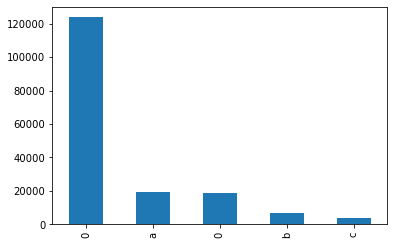

In [17]:
# Checking whether there was a state holiday when the store was closed
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

In [18]:
# Checking missing values in train set - no missing value
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [19]:

# No. of days with closed stores
train[(train.Open == 0)].shape[0]

172817

In [20]:

# Checking missing values in store data 
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:

# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [22]:

# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [23]:
# Checking missing values
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [24]:
# Assuming stores open in test
test.fillna(1, inplace=True)

In [25]:
# Joining the tables
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [26]:

# Distribution of sales and customers across store types
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)


,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


In [27]:
train_store_joined[(train_store_joined.Open ==0) | (train_store_joined.Sales==0)].shape


(172871, 22)

In [28]:
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]


In [29]:

#Correlation Analysis

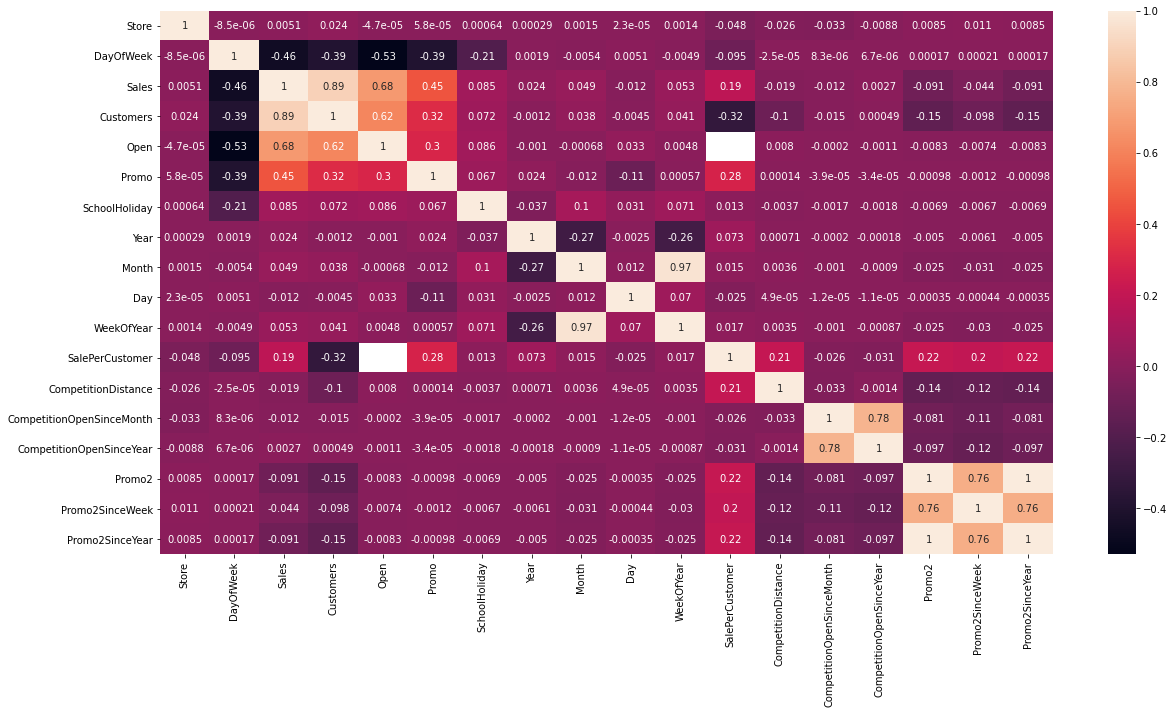

In [30]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True);

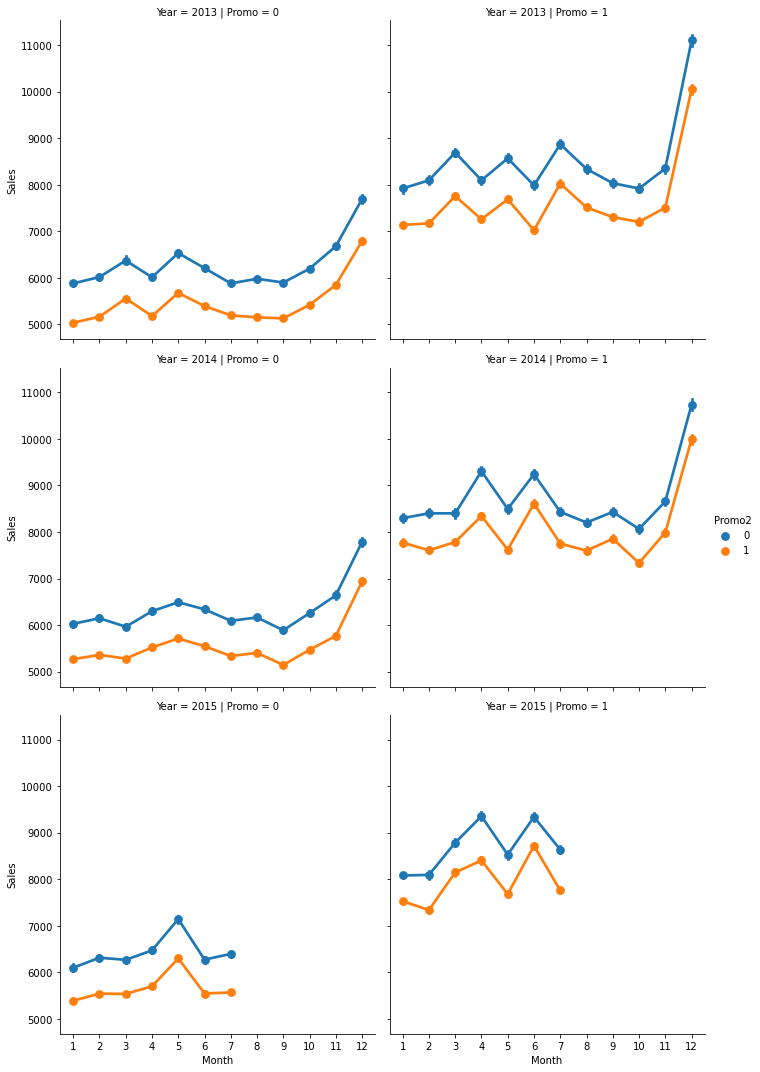

In [31]:
# Sales trend over the months
sns.factorplot(data = train_store_joined_open, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
             );

spikes from novemeber and december

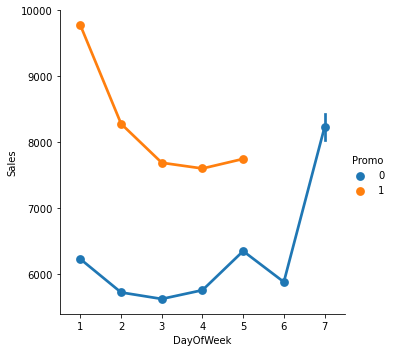

In [32]:

# Sales trend over days
sns.factorplot(data = train_store_joined_open, x = "DayOfWeek", y = "Sales", hue = "Promo");

a) The most selling and crowded StoreType is A.

b) StoreType B has the highest Sale per Customer.

c) Customers tends to buy more on Mondays when there are ongoing promotional offers and on Thursdays/Fridays when there is no promotion at all.

d) Second promotion (Promo2) doesn't seem to contribute in the increase of sales.

# Part B - Time Series Analysis & Predictive Modelling¶


In [33]:
pd.plotting.register_matplotlib_converters()

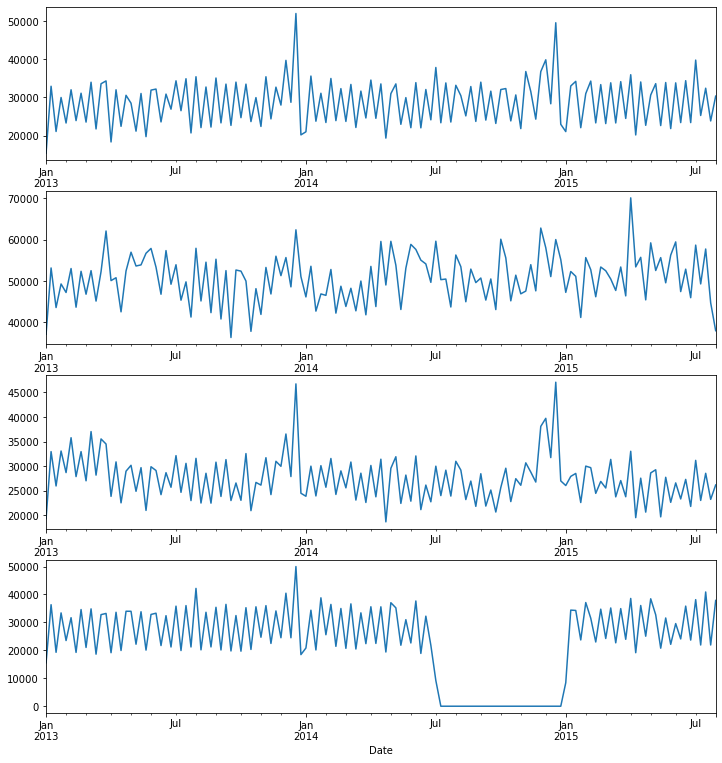

In [34]:


# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

In [35]:
sales_b

Date
2013-01-01    4220.0
2013-01-02    6069.0
2013-01-03    5246.0
2013-01-04    5339.0
2013-01-05    5774.0
               ...  
2015-07-27    7788.0
2015-07-28    7533.0
2015-07-29    7719.0
2015-07-30    7187.0
2015-07-31    7791.0
Name: Sales, Length: 942, dtype: float64

<AxesSubplot:xlabel='Date'>

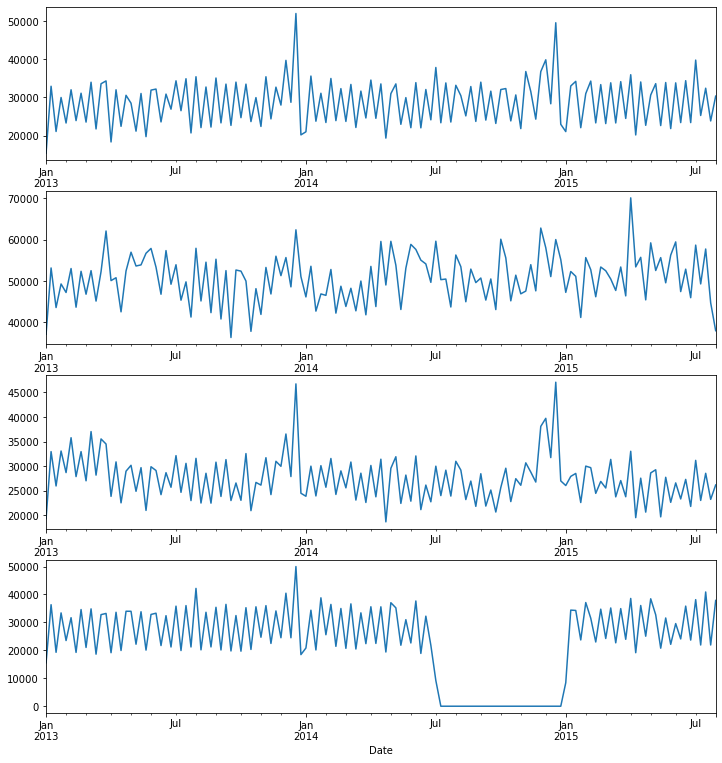

In [36]:
# Trend
f,(ax1,ax2,ax3,ax4) =plt.subplots(4,figsize= (12,13))
sales_a.resample('W').sum().plot(ax=ax1)
sales_b.resample('W').sum().plot(ax=ax2)
sales_c.resample('W').sum().plot(ax=ax3)
sales_d.resample('W').sum().plot(ax=ax4)

In [37]:
def test_stationarity(timeseries):
    #determining rolling stastics
    roll_mean= timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    #plotting 
    org = plt.plot(timeseries.resample('W').mean(),color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(),color = 'red',label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(),color ='green', label='Rolling Std')
    plt.legend(loc ='best')
    plt.show(block=False )
    
    print('Result of Dickey puller test: ')
    result = adfuller(timeseries,autolag='AIC')
    print('ADF Stastics : %f'%result[0])
    print('P- value : %f'%result[1])
    print('Critical value')
    for key,value in result[4].items():
        print(key,value)
    
    

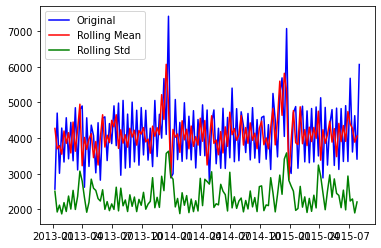

Result of Dickey puller test: 
ADF Stastics : -24.817688
P- value : 0.000000
Critical value
1% -3.4373183615045266
5% -2.864616349295443
10% -2.568408028822753


In [38]:
test_stationarity(sales_a)

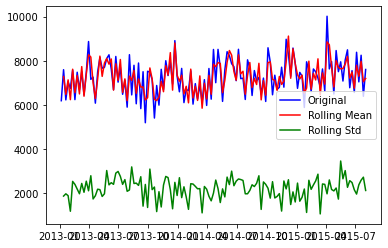

Result of Dickey puller test: 
ADF Stastics : -5.660918
P- value : 0.000001
Critical value
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [39]:
test_stationarity(sales_b)

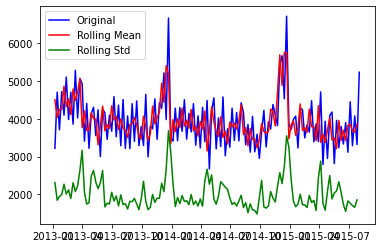

Result of Dickey puller test: 
ADF Stastics : -4.374784
P- value : 0.000329
Critical value
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [40]:
test_stationarity(sales_c)

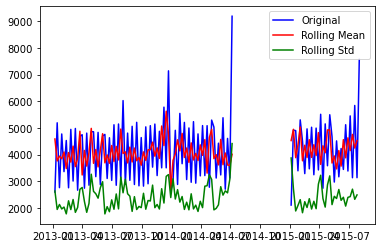

Result of Dickey puller test: 
ADF Stastics : -6.237461
P- value : 0.000000
Critical value
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [41]:
test_stationarity(sales_d)

    Dicky -Fuller test: This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [42]:
def plot_timeseries(sales,StoreType):
    
    fig,axes =  plt.subplots(2,1,  sharex=True, sharey=False)
    #fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    decomposition = seasonal_decompose(sales,model ='addative',freq=365)
    
    estimated_trend =decomposition.trend
    estimated_seasonal =decomposition.seasonal
    estimated_residual =decomposition.resid
    
    axes[1].plot(estimated_seasonal,'g',label='Seasonality')
    axes[1].legend(loc='upper left')
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')
    
    plt.title('Decomposition Plots')

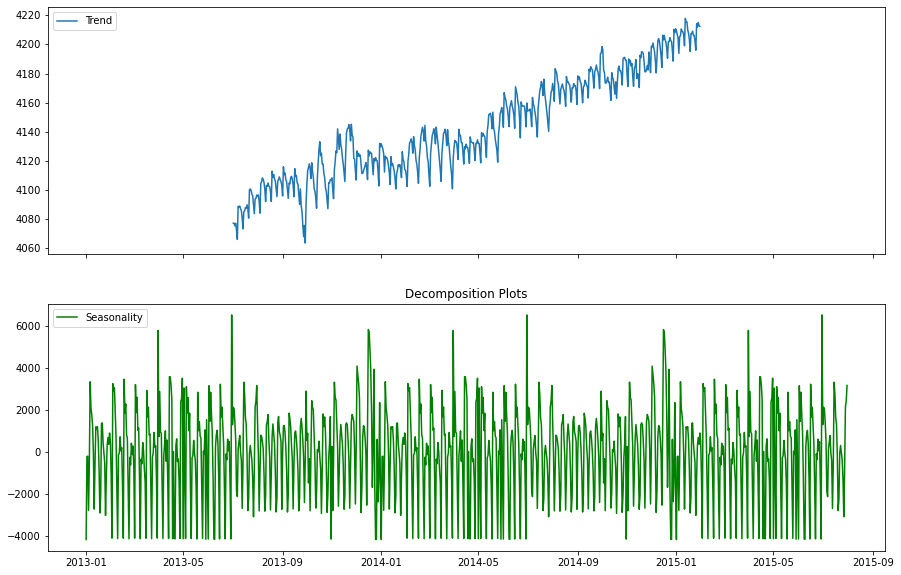

In [43]:
plot_timeseries(sales_a,'a')

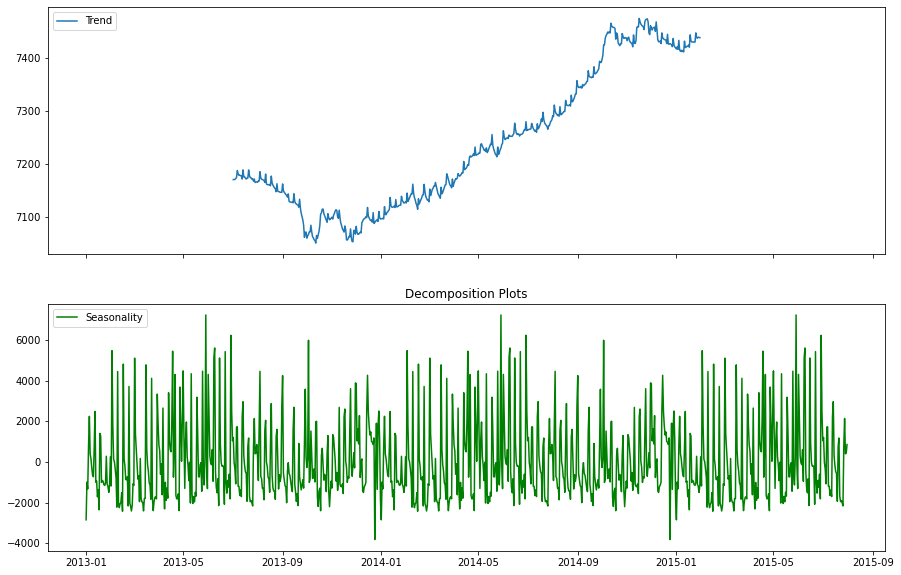

In [44]:
plot_timeseries(sales_b,'b')

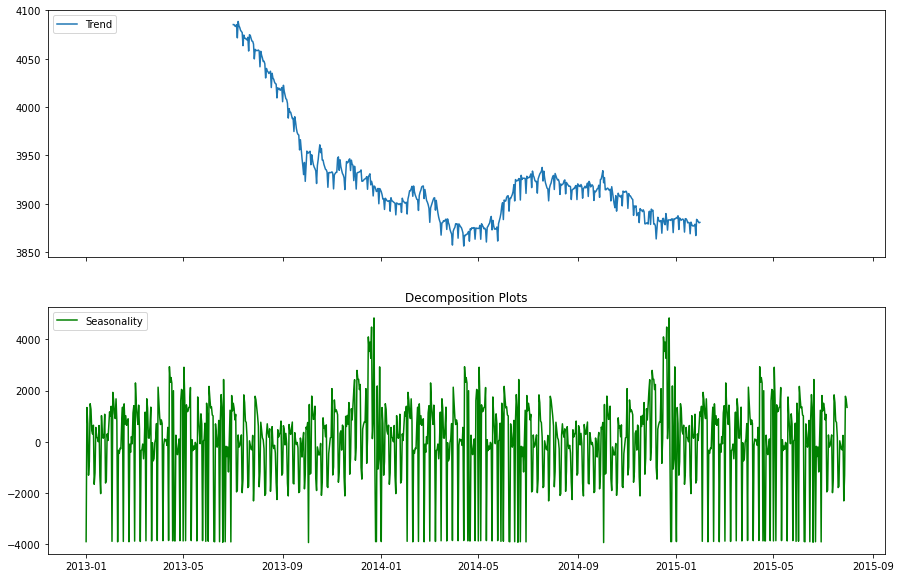

In [45]:
plot_timeseries(sales_c,'c')

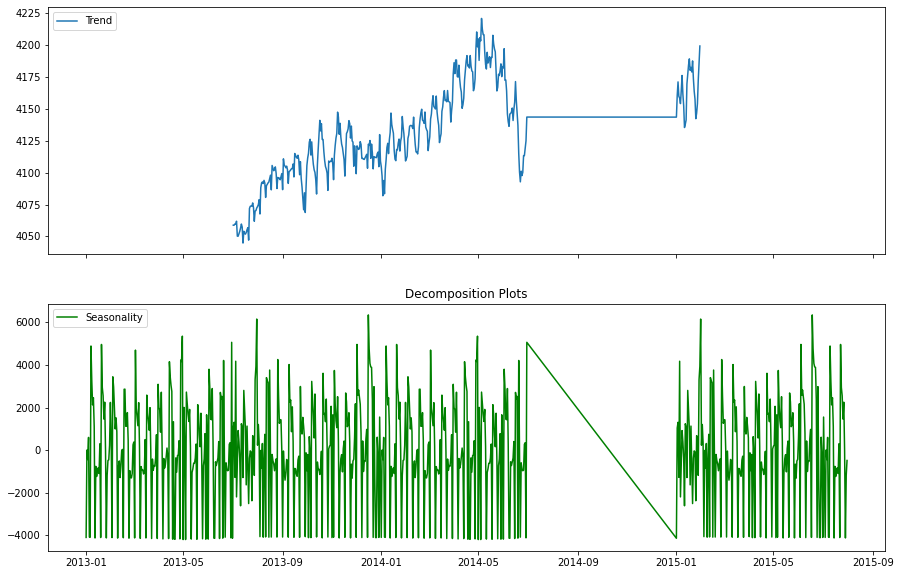

In [46]:
plot_timeseries(sales_d,'d')

#    Evaluation matrics
    

MAE is easier to understand and interpret but RMSE works well in situations where large errors are undesirable. 
This is because the errors are squared before they are averaged, thus penalizing large errors. In our case, RMSE suits well because we want to predict the sales with minimum error 
(i.e penalize high errors) so that inventory can be managed properly.

p represents number of Autoregressive terms - lags of dependent variable.
q represents number of Moving Average terms - lagged forecast errors in prediction equation. 
d represents number of non-seasonal differences.
    



ACF - measure of correlation between time series with a lagged version of itself.

PACF - measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

p value is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.

q value is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.



In [47]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

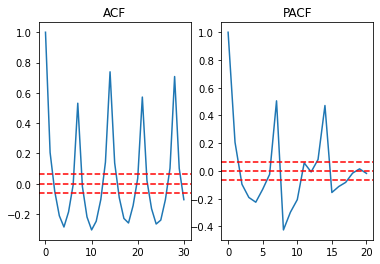

In [48]:

# ACF and PACF for store type a
auto_corr(sales_a)

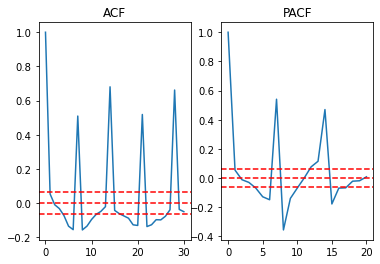

In [50]:
auto_corr(sales_b)

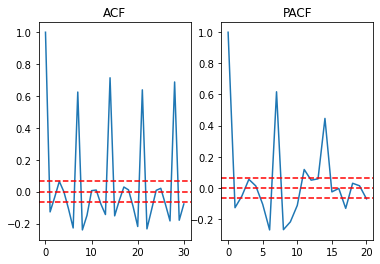

In [52]:

auto_corr(sales_c)

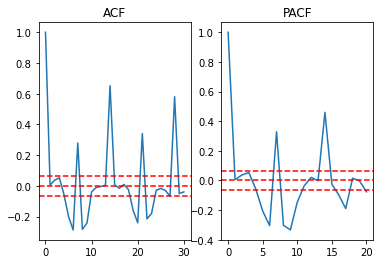

In [54]:
#auto_corr(sales_d)
auto_corr(sales_d)

<AxesSubplot:xlabel='Date'>

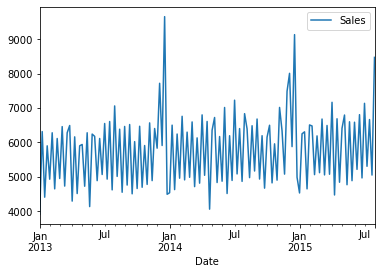

In [55]:
#summing the sales on per week
train_arima = train.resample('W').mean()
train_arima = train_arima[["Sales"]] 
train_arima.plot()

# Hyper tuning ARIMA 

In [56]:
#define the p,q,d, value between 0-2
p = q = d = range(0,2)

#generate all 3 different combinations p,q,d triplets 
pdq = list(itertools.product(p,d,q))

#generate all 3 different combinations of seasonal p,q,d triplets
seasonal_pdq = [(x[0], x[1], x[2], 12)  for x in list(itertools.product(p,d,q))]

print('print the combinations of seasonal Arima ')
print ('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print ('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print ('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print ('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


print the combinations of seasonal Arima 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [59]:
#lets see lowest AIC

#determine p,d,q combination with AIC score
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =sm.tsa.statespace.SARIMAX(train_arima,
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_invertibility=False,
                                          enforce_stationarity=False)
            result = mod.fit()
            print('ARIMA: {} x {} 12 - AIC:{}'.format(param,param_seasonal,result.aic))
        except:
            continue 

ARIMA: (0, 0, 0) x (0, 0, 0, 12) 12 - AIC:2708.8196371542945
ARIMA: (0, 0, 0) x (0, 1, 0, 12) 12 - AIC:2142.9121481207667
ARIMA: (0, 0, 0) x (0, 1, 1, 12) 12 - AIC:1893.8220522795723
ARIMA: (0, 0, 0) x (1, 0, 0, 12) 12 - AIC:2163.085669279766
ARIMA: (0, 0, 0) x (1, 0, 1, 12) 12 - AIC:2116.7057912673436
ARIMA: (0, 0, 0) x (1, 1, 0, 12) 12 - AIC:1919.9439695857754
ARIMA: (0, 0, 0) x (1, 1, 1, 12) 12 - AIC:1894.9524107197126
ARIMA: (0, 0, 1) x (0, 0, 0, 12) 12 - AIC:2592.3366943402293
ARIMA: (0, 0, 1) x (0, 0, 1, 12) 12 - AIC:2305.886830498194
ARIMA: (0, 0, 1) x (0, 1, 0, 12) 12 - AIC:2103.0171891135674
ARIMA: (0, 0, 1) x (0, 1, 1, 12) 12 - AIC:1856.635325966469
ARIMA: (0, 0, 1) x (1, 0, 0, 12) 12 - AIC:2146.0426171360336
ARIMA: (0, 0, 1) x (1, 0, 1, 12) 12 - AIC:2066.908597164683
ARIMA: (0, 0, 1) x (1, 1, 0, 12) 12 - AIC:1902.441508975204
ARIMA: (0, 0, 1) x (1, 1, 1, 12) 12 - AIC:1852.884184252314
ARIMA: (0, 1, 0) x (0, 0, 0, 12) 12 - AIC:2368.481953362583
ARIMA: (0, 1, 0) x (0, 0, 1, 12

 ARIMA: (1, 1, 1) x (0, 1, 1, 12) 12 - AIC:1806.2981906704808 is considered as lowest will use in our project 
# Fitting model using above hyperparamter tuned 

In [58]:
#fitting the data in SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(0, 1, 1, 12),
                                        enforce_invertibility=False,
                                        enforce_stationarity=False)
results_sarima =model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323
ma.L1         -0.9559      0.050    -19.076      0.000      -1.054      -0.858
ma.S.L12      -1.0120      0.831     -1.218      0.223      -2.640       0.616
sigma2      8.268e+05   7.31e+05      1.131      0.258   -6.06e+05    2.26e+06


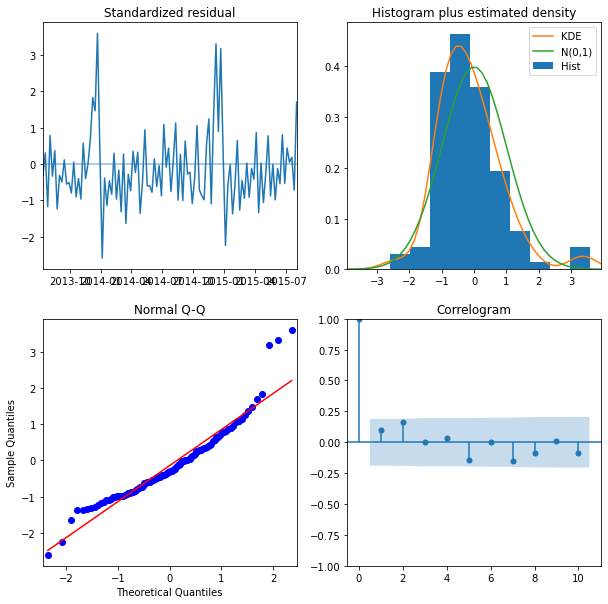

In [62]:
#checking diagonestic plots
results_sarima.plot_diagnostics(figsize=(10,10))
plt.show()

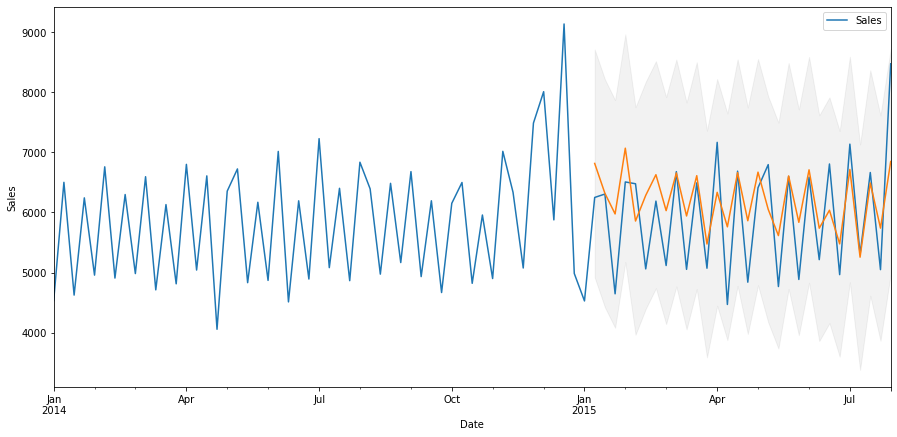

Root Mean Squared Error:  739.061168745832


In [59]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

## Model 2 - Prophet

In [60]:
#creating a train dataset
train_prophet =train.copy()
train_prophet.reset_index(level=0,inplace= True)

In [61]:
#creating the column name required by prophet library
train_prophet = train_prophet.rename(columns={'Date':'ds',
                                             'Sales':'y'})
train_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
1,2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400
2,2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675
3,2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457
4,2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118


In [67]:
#downsampling to week beacuse data is daily basis and will take time
ts_week_prophet = train_prophet.set_index('ds').resample('W').sum()
ts_week_prophet.head()

,Store,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
ds,,,,,,,,,,,,
2013-01-06,3732032,30103,26129335.0,3110602,4471,0,4533,13464957,6689,23414,6689,39406.143319
2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,560,15711465,7805,78050,15610,65076.326540
2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0,15711465,7805,132685,23415,57208.229656
2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0,15711465,7805,187320,31220,65073.831993
2013-02-03,4355190,31220,38466029.0,4507650,6667,0,128,15711465,11150,138260,39025,59686.174407


In [80]:
pip install --upgrade fbprophet

Requirement already up-to-date: fbprophet in c:\users\vivek\anaconda3\lib\site-packages (0.6)
Note: you may need to restart the kernel to use updated packages.


### initial/baseline prophet model

In [70]:
#fitting data to prophet model
prophet_1 = Prophet()
prophet_1.fit(ts_week_prophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
# Resetting the index
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,2013-01-06,3732032,30103,26129335.0,3110602,4471,0,4533,13464957,6689,23414,6689,39406.143319
1,2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,560,15711465,7805,78050,15610,65076.326540
2,2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0,15711465,7805,132685,23415,57208.229656
3,2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0,15711465,7805,187320,31220,65073.831993
4,2013-02-03,4355190,31220,38466029.0,4507650,6667,0,128,15711465,11150,138260,39025,59686.174407


In [71]:
future_1 = prophet_1.make_future_dataframe(periods=52,freq='W')
forecast_1 = prophet_1.predict(future_1)
forecast_1[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.445992e+07,3.397492e+07,5.378286e+07
183,2016-07-10,4.410754e+07,3.479414e+07,5.403061e+07
184,2016-07-17,4.435100e+07,3.506617e+07,5.383196e+07
185,2016-07-24,4.423844e+07,3.484795e+07,5.439659e+07
186,2016-07-31,4.344689e+07,3.349378e+07,5.291089e+07


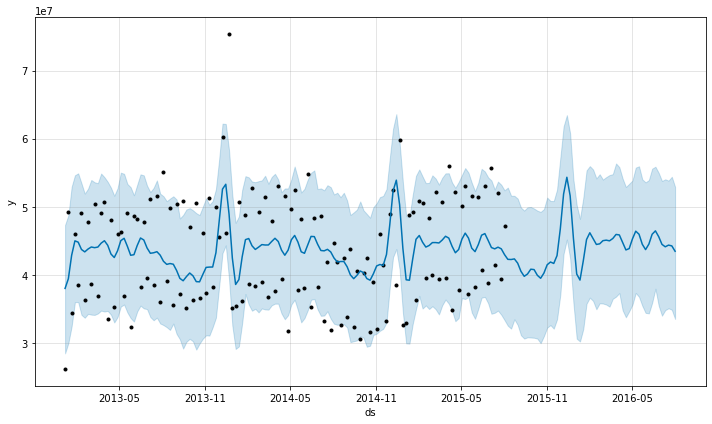

In [72]:
#visualizing the predction 
prophet_1.plot(forecast_1);

In [95]:
#checking the RMSE of prophet model
metric_prophet_1=  forecast_1.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)
rms_prophet_1 = mean_squared_error(metric_prophet_1.y,metric_prophet_1.yhat)
rms_prophet_1

53782485769688.98

In [73]:
train_prophet.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [74]:
#encoding state holiday categorical variable
train_prophet['StateHoliday_cat']=train_prophet['StateHoliday'].map({0:0,'0':0 ,'a':1, 'b':1, 'c':1})
train_prophet.head();

In [75]:
#choosing only required columns
train_prophet= train_prophet[['ds','y','StateHoliday','StateHoliday_cat']]
train_prophet.head()

,ds,y,StateHoliday,StateHoliday_cat
0,2015-07-31,5263.0,0,0
1,2015-07-31,6064.0,0,0
2,2015-07-31,8314.0,0,0
3,2015-07-31,13995.0,0,0
4,2015-07-31,4822.0,0,0


In [76]:
#modeling holidays- creating holidays dataframe
state_dates = train_prophet[(train_prophet.StateHoliday_cat==1)].loc[:,'ds'].values
school_dates = train_prophet[(train_prophet.StateHoliday==1)].loc[:,'ds'].values


state = pd.DataFrame({'holiday':'state_holiday','ds':pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday':'school_holiday','ds':pd.to_datetime(school_dates)})

holidays = pd.concat((state,school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [77]:
train_prophet.head()

,ds,y,StateHoliday,StateHoliday_cat
0,2015-07-31,5263.0,0,0
1,2015-07-31,6064.0,0,0
2,2015-07-31,8314.0,0,0
3,2015-07-31,13995.0,0,0
4,2015-07-31,4822.0,0,0


In [78]:
#dropping holiday column not needed any more 
train_prophet_clean = train_prophet.drop(['StateHoliday','StateHoliday_cat'],axis=1)
train_prophet_clean.head()

,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [79]:
#downsampling the week because modeling on daily basis will take more time 
ts_week_prophet = train_prophet_clean.set_index('ds').resample('W').sum()
#ts_week_prophet = train_prophet_clean.set_index("ds").resample("W").sum()

ts_week_prophet.head()

,y
ds,
2013-01-06,26129335.0
2013-01-13,49275222.0
2013-01-20,34377765.0
2013-01-27,46040169.0
2013-02-03,38466029.0


In [80]:
#resetting the index 
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,y
0,2013-01-06,26129335.0
1,2013-01-13,49275222.0
2,2013-01-20,34377765.0
3,2013-01-27,46040169.0
4,2013-02-03,38466029.0


In [81]:
#fitting the data to the prophet model
prophet_2 =Prophet(holidays=holidays, interval_width=0.95,growth='linear',yearly_seasonality =True )
prophet_2.fit(ts_week_prophet_train)
print('done')

future_2 = prophet_2.make_future_dataframe(periods = 52 ,freq ='W')
forecast_2 = prophet_2.predict(future_2)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


done


In [82]:
forecast_2 [['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.430179e+07,3.028806e+07,5.880360e+07
183,2016-07-10,4.393404e+07,3.004101e+07,5.818202e+07
184,2016-07-17,4.408599e+07,3.070793e+07,5.735442e+07
185,2016-07-24,4.393618e+07,3.012098e+07,5.813210e+07
186,2016-07-31,4.321431e+07,2.888933e+07,5.791091e+07


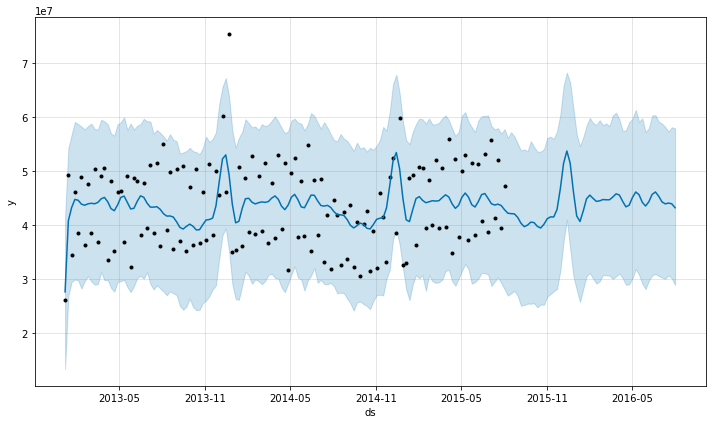

In [83]:
#visualizing the graph
prophet_2.plot(forecast_2);

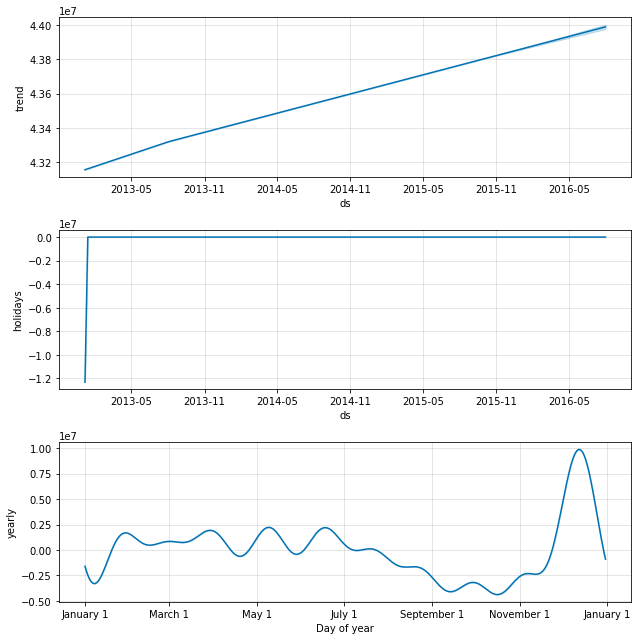

In [84]:
#visualize trend and seasonality components
prophet_2.plot_components(forecast_2);


In [85]:
metric_prophet_2 = forecast_2.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_2.dropna(inplace=True)
rms_prophet_2 = mean_squared_error(metric_prophet_2.y, metric_prophet_2.yhat)
rms_prophet_2

52554486447395.586

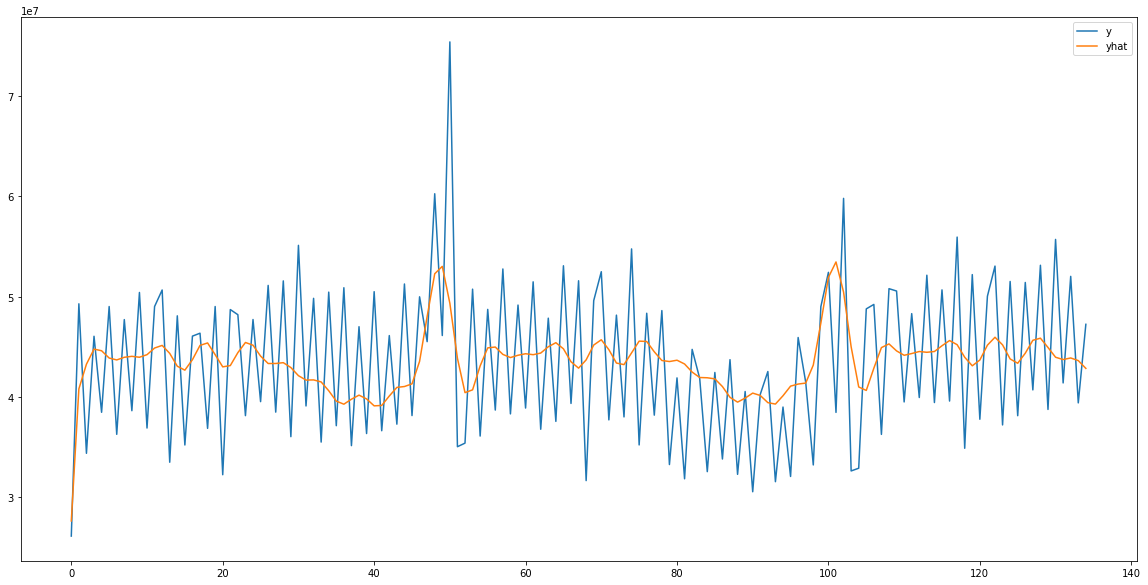

In [86]:
#visualizing the performance of model
plt.figsize=(10,20)
metric_prophet_2['y'].plot(figsize=(20,10))
metric_prophet_2['yhat'].plot()
plt.legend()
plt.show()

Our baseline Prophet model used default parameters and we got RMSE of 53782649094881.14 and after hyper tuning, we got RMSE of 52478331938232.15. Although the final model is performing better it is still performing poorly as compared to ARIMA. So, let's try another model.

### Model 3 - XGBoost


In [96]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)

In [97]:

# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [98]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [99]:
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)

In [94]:
#splitting the data
features = ts_xgboost.drop(['Sales'],axis=1)
target =ts_xgboost['Sales']
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size=0.33, random_state=42)

### initial  baseline XGboost

In [100]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[10:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5164.59863	eval-rmse:5161.24463
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:4015.12402	eval-rmse:4011.37817
[2]	train-rmse:3299.26709	eval-rmse:3295.83911
[3]	train-rmse:2877.87549	eval-rmse:2875.02588
[4]	train-rmse:2641.78125	eval-rmse:2639.08057
[5]	train-rmse:2503.57202	eval-rmse:2500.78613
[6]	train-rmse:2423.91431	eval-rmse:2422.00122
[7]	train-rmse:2381.24512	eval-rmse:2379.00000
[8]	train-rmse:2331.57788	eval-rmse:2326.81567
[9]	train-rmse:2306.76147	eval-rmse:2301.86084
[10]	train-rmse:2272.84766	eval-rmse:2267.82202
[11]	train-rmse:2252.72412	eval-rmse:2247.30225
[12]	train-rmse:2244.70142	eval-rmse:2239.22339
[13]	train-rmse:2231.19458	eval-rmse:2226.13550
[14]	train-rmse:2

In [101]:
#rmse for model
rms_xgboost = sqrt(mean_squared_error(y_test,preds))
print('root mean square error for xgboost : ',rms_xgboost)

root mean square error for xgboost :  1217.4419774522046


### hyper tunning2 

In [ ]:
eta : it defines learning rate, stpe size lets make it .2 small, which will reduce the overfitting
max_depth = minimum is 6 lets make it to 10
gamma: minimum loss reduction to make a further partation of a leaf nod of tree

In [104]:
#tunning parameter 
param_2 ={'max_depth':10,'eta':.1,'gamma':2}

dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)
watchlist = [(dtrain,'train'),(dtest,'eval')]

xgboost_2 = xgb.train(param_2,dtrain,100,evals=watchlist,early_stopping_rounds=100,verbose_eval=True)

preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:6324.77002	eval-rmse:6321.70947
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5778.17871	eval-rmse:5775.76562
[2]	train-rmse:5293.18701	eval-rmse:5291.60059
[3]	train-rmse:4861.69043	eval-rmse:4860.81787
[4]	train-rmse:4481.20166	eval-rmse:4481.09082
[5]	train-rmse:4147.43945	eval-rmse:4147.56348
[6]	train-rmse:3853.10864	eval-rmse:3853.94751
[7]	train-rmse:3597.06763	eval-rmse:3598.36987
[8]	train-rmse:3370.40161	eval-rmse:3372.54663
[9]	train-rmse:3175.92627	eval-rmse:3179.06567
[10]	train-rmse:3006.63672	eval-rmse:3009.96680
[11]	train-rmse:2864.01343	eval-rmse:2867.73877
[12]	train-rmse:2737.16211	eval-rmse:2741.45654
[13]	train-rmse:2629.95215	eval-rmse:2634.86279
[14]	train-rmse:2537.35547	eval-rmse:2542.81543
[15]	train-rmse:2454.22144	eval-rmse:2460.58008
[16]	train-rmse:2386.62085	eval-rmse:2393.62939
[17]	train-rmse:2332.92212	eval-rmse:2340.68994
[1

In [106]:
#RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
#rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))

print('print root means square error:  ',rms_xgboost_2)

print root means square error:   1172.866802508717


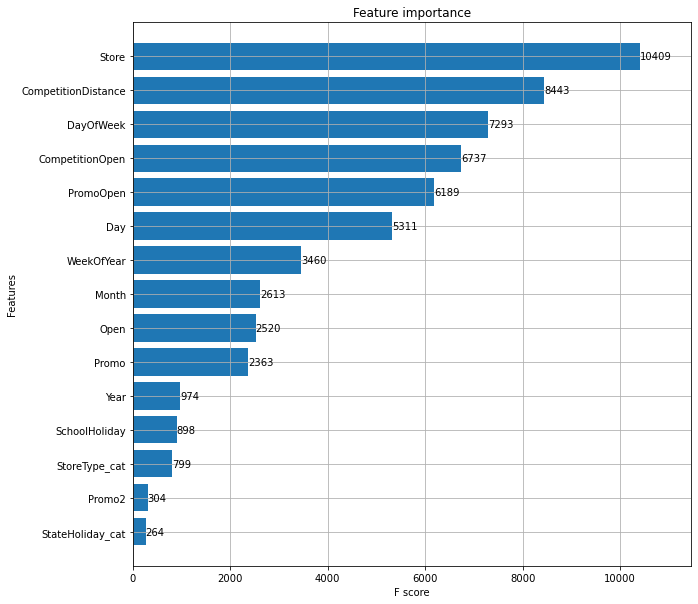

In [108]:
#let see the feature important 
fig,ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(figsize=(10,10))

xgb.plot_importance(xgboost_2,max_num_features=50,height=.8,ax=ax)
plt.show()


In [ ]:
Final xgboost Model
afterhypertunning , we were able to reduce RMSE from 1226.99 from 1172.0 let compare the results

In [113]:
#comparing performance of above three model
rms_arima =   format(float(rms_arima))
rms_prophet_2 = format(float(rms_prophet_2))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
                    'Model':['SARIMA','PROPHET','XGBOOST'],
                    'RMSE':[rms_arima,rms_prophet_2,rms_xgboost_2]})

#model_errors.sort_values(by = "RMSE")
model_errors.sort_values(by = "RMSE")


,Model,RMSE
2,XGBOOST,1172.866802508717
1,PROPHET,52554486447395.586
0,SARIMA,739.061168745832


In [ ]:
SARIMA perform well, then XGBOOST, then PROPHET
SARIMA is only designed for the timeseries 
PROPHET is good choice for quick forcast 